## Lecture 2: Data Prep, Model Adaptation & Feature Extraction

**Recap from Lecture 1:**
* We introduced the final project: Comparing fine-tuned models (MobileNetV3 vs. ResNet18) for Pet Breed Classification.
* We introduced the Oxford-IIIT Pet dataset (37 breeds).
* We showed basic code to load the dataset using `torchvision` with `Resize` and `ToTensor` transforms.

**Goals for Today (Lecture 2):**
1.  **Complete Data Preprocessing:** Add ImageNet normalization to our transforms and create `DataLoader`s.
2.  **Load & Adapt Models:** Load pre-trained MobileNetV3 and ResNet18 from `torchvision` and modify their final classification layers for our 37 pet breeds.
3.  **Implement Feature Extraction:** Freeze the pre-trained layers and train *only* the new classification head for one model as a baseline.
4.  **Set up Training:** Define loss function, optimizer, and basic training/validation loops.
5.  **Run Demo:** Train the classifier head for a few epochs.

In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

print("Libraries imported.")

Libraries imported.


In [2]:
# --- Define Complete Transforms (including Normalization) ---

# Pre-trained models expect input images normalized in the same way as the ImageNet dataset.
# We use the standard ImageNet mean and standard deviation values.
# Normalization formula: input[channel] = (input[channel] - mean[channel]) / std[channel]
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define transforms for training (we'll add augmentation in L3) and validation/testing
# Validation/Test transforms typically don't include random augmentations.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),       # Resize images
        transforms.ToTensor(),               # Convert image to PyTorch Tensor
        transforms.Normalize(imagenet_mean, imagenet_std) # Normalize with ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ]),
}
print("Data transforms defined (including ImageNet normalization).")

Data transforms defined (including ImageNet normalization).


In [3]:
# --- Load the Oxford-IIIT Pet Dataset using the new transforms ---
data_root = './data'
print(f"\nLoading datasets from {data_root}...")

# Use 'trainval' for training, 'test' for validation in this setup
# Note: A separate validation split is often preferred, but for simplicity here we use 'test' as validation
train_dataset = torchvision.datasets.OxfordIIITPet(
    root=data_root,
    split='trainval',
    download=True, # Should already be downloaded from L1
    transform=data_transforms['train'] # Apply training transforms
)

val_dataset = torchvision.datasets.OxfordIIITPet(
    root=data_root,
    split='test',     # Using the test split as our validation set here
    download=True,
    transform=data_transforms['val'] # Apply validation transforms
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")


Loading datasets from ./data...
Training dataset size: 3680
Validation dataset size: 3669
Number of classes: 37


In [4]:
# --- Create DataLoaders ---
# DataLoaders handle batching, shuffling, and loading data in parallel.
batch_size = 32 # Adjust based on your system's memory

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2), # num_workers > 0 for parallel loading
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

print(f"\nDataLoaders created with batch size {batch_size}.")
print("Ready for model loading and adaptation.")


DataLoaders created with batch size 32.
Ready for model loading and adaptation.


In [5]:
# Example: Get one batch of training images and labels
inputs, classes = next(iter(dataloaders['train']))
print(f"\nSample batch input shape: {inputs.shape}") # e.g., [32, 3, 224, 224]
print(f"Sample batch labels shape: {classes.shape}") # e.g., [32]


Sample batch input shape: torch.Size([32, 3, 224, 224])
Sample batch labels shape: torch.Size([32])


### Loading Pre-trained Models & Adapting the Classifier Head

Now that our data is ready, we'll load the pre-trained models from `torchvision.models`:

1.  First, we run `torchvision.models.<model_name>(weights=...)` to get a model pre-trained on ImageNet. We'll use the recommended modern way of specifying weights.
2.  We initially want to train *only* the final classification layer (Feature Extraction). To do this, we freeze the parameters of all other layers by setting `parameter.requires_grad = False`.
3.  The pre-trained models have a final layer designed for ImageNet's 1000 classes. We need to replace this with a new layer suited for our 37 pet breeds. We must ensure the `in_features` of the new layer matches the `out_features` of the preceding layer.

In [6]:
# --- Load and Adapt MobileNetV3 ---

print("Loading pre-trained MobileNetV3 Large...")
# Load MobileNetV3 Large with the best available ImageNet weights
mobilenet_v3 = torchvision.models.mobilenet_v3_large(weights=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Display the model architecture
print(mobilenet_v3)

Loading pre-trained MobileNetV3 Large...
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 

In [7]:
# --- Freeze all parameters in the base model ---
print("Freezing base model parameters...")
for param in mobilenet_v3.parameters():
    param.requires_grad = False

# --- Replace the classifier head ---
# MobileNetV3's classifier is typically the last element in the `classifier` Sequential block.
# We need to find the number of input features to this layer.
num_ftrs_mobilenet = mobilenet_v3.classifier[-1].in_features
print(f"Original MobileNetV3 classifier input features: {num_ftrs_mobilenet}")

# Create a new nn.Linear layer for our 37 classes
# The parameters of this new layer have requires_grad=True by default.
mobilenet_v3.classifier[-1] = nn.Linear(num_ftrs_mobilenet, num_classes)
print("Replaced MobileNetV3 classifier head.")

Freezing base model parameters...
Original MobileNetV3 classifier input features: 1280
Replaced MobileNetV3 classifier head.


In [8]:
# --- Verify which parameters are trainable ---
print("\nTrainable parameters in modified MobileNetV3:")
total_params_mobilenet = 0
trainable_params_mobilenet = 0
for name, param in mobilenet_v3.named_parameters():
    total_params_mobilenet += param.numel()
    if param.requires_grad:
        print(f"  - {name} (Size: {param.shape}, Params: {param.numel()})")
        trainable_params_mobilenet += param.numel()

print(f"\nTotal parameters in MobileNetV3: {total_params_mobilenet:,}")
print(f"Trainable parameters (classifier head only): {trainable_params_mobilenet:,}")


Trainable parameters in modified MobileNetV3:
  - classifier.3.weight (Size: torch.Size([37, 1280]), Params: 47360)
  - classifier.3.bias (Size: torch.Size([37]), Params: 37)

Total parameters in MobileNetV3: 4,249,429
Trainable parameters (classifier head only): 47,397


In [9]:
#display the new model head
print("\nModified MobileNetV3 Classifier Head:")
print(mobilenet_v3.classifier)


Modified MobileNetV3 Classifier Head:
Sequential(
  (0): Linear(in_features=960, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=37, bias=True)
)


In [10]:
# make predictions on modified model to see baseline accuracy before fine-tuning
import torch

# Set up device (MPS for M2 Mac, fallback to CPU)
# Check if MPS is available and PyTorch version is compatible
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Fallback to CUDA then CPU

print(f"Using device: {device}")
mobilenet_v3.to(device) # Move the model to the chosen device

# Evaluation function
@torch.no_grad() # Decorator for efficiency, equivalent to 'with torch.no_grad():'
def evaluate(model, dataloader, device):
    model.eval() # Set model to evaluation mode
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    model.train() # Set model back to train mode just in case
    return accuracy

# Evaluate on the test set *before* training the head
print("Evaluating baseline performance (random head)...")
baseline_accuracy = evaluate(mobilenet_v3, dataloaders['val'], device)
print(f'Accuracy on the test set before fine-tuning: {baseline_accuracy:.2f} %')

Using device: mps
Evaluating baseline performance (random head)...
Accuracy on the test set before fine-tuning: 2.13 %


### Feature Extraction Training Strategy

We now have two models (MobileNetV3 and ResNet18) adapted for our task, with only their final classification layers being trainable. As we discussed last class, this process is called "feature extraction", because we rely on the pre-training model to extract some useful information or features (the output that is fed into the final classification layer). Note that:
* It's fast, as we only compute gradients and update weights for the small classifier layer.
* It quickly establishes a baseline performance by leveraging the powerful, pre-trained features from the frozen base model.
* It initializes the weights of our new classifier head reasonably well before we potentially unfreeze more layers later for fine-tuning.

**Training Setup:**
* *Loss Function:* `nn.CrossEntropyLoss` is standard for multi-class classification. It combines LogSoftmax and Negative Log Likelihood Loss.
* *Optimizer:* We'll use `optim.Adam`. Crucially, we must configure it to *only* update the parameters of the newly added classification layer (those with `requires_grad=True`).
* *Device:* We'll use a GPU (`cuda` or `mps`) if available, otherwise fallback to CPU.

In [11]:
# Check if MPS is available and PyTorch version is compatible
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Fallback to CUDA then CPU
print(f"\nUsing device: {device}")


Using device: mps


In [12]:
# --- Training and Validation Helper Functions ---

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Performs one epoch of training."""
    model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in dataloader:
        # Move data to the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1) # Get the index of the max logit/score

        # Backward pass + optimize only if in training phase
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        # use .item() to pull the scalar off MPS to host
        running_corrects += (preds == labels).sum().item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Performs one epoch of validation."""
    model.eval() # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # No gradients needed for validation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            # use .item() to pull the scalar off MPS to host
            running_corrects += (preds == labels).sum().item()
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

print("Training and validation helper functions defined.")

Training and validation helper functions defined.


In [13]:
# --- Feature Extraction Training Run ---

# Let's use MobileNetV3 for the first run.
model_to_train = mobilenet_v3
model_name = "MobileNetV3_FeatureExtract"

# Move the model to the chosen device
model_to_train = model_to_train.to(device)
print(f"Training model: {model_name} on {device}")

# --- Define Loss and Optimizer ---
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
# IMPORTANT: We only want to optimize the parameters of the NEW classifier head.
# We can filter parameters based on requires_grad == True.
params_to_update = []
print("\nParameters to be optimized:")
for name, param in model_to_train.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print(f"  - {name}")

optimizer = optim.Adam(params_to_update, lr=0.001) # Common learning rate for Adam
print("\nOptimizer created (Adam, lr=0.001) targeting only the classifier head.")

Training model: MobileNetV3_FeatureExtract on mps

Parameters to be optimized:
  - classifier.3.weight
  - classifier.3.bias

Optimizer created (Adam, lr=0.001) targeting only the classifier head.


In [14]:
# --- Training Loop ---
num_epochs = 5 # Train for a few epochs for demonstration
print(f"\nStarting Feature Extraction training for {num_epochs} epochs...")

start_time_train = time.time()

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model_to_train, dataloaders['train'], criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    # Validate
    val_loss, val_acc = validate(model_to_train, dataloaders['val'], criterion, device)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # --- Store metrics for plotting ---
    train_losses.append(train_loss)
    train_accs.append(train_acc) # Use .item() to get scalar value if it's a tensor
    val_losses.append(val_loss)
    val_accs.append(val_acc) # Use .item() to get scalar value if it's a tensor

end_time_train = time.time()
training_duration = end_time_train - start_time_train
print(f"\nTraining finished in {training_duration // 60:.0f}m {training_duration % 60:.0f}s")

# --- The variables train_losses, val_losses, train_accs, val_accs now hold the history ---
print("\nMetric history collected:")
print(f"Train Losses per epoch: {[f'{x:.4f}' for x in train_losses]}")
print(f"Val Losses per epoch:   {[f'{x:.4f}' for x in val_losses]}")
print(f"Train Accs per epoch:   {[f'{x:.4f}' for x in train_accs]}")
print(f"Val Accs per epoch:     {[f'{x:.4f}' for x in val_accs]}")


Starting Feature Extraction training for 5 epochs...

Epoch 1/5
----------
Train Loss: 1.7366 Acc: 0.6312
Val Loss: 0.7399 Acc: 0.8084

Epoch 2/5
----------
Train Loss: 0.6764 Acc: 0.8677
Val Loss: 0.6812 Acc: 0.8070

Epoch 3/5
----------
Train Loss: 0.4583 Acc: 0.9106
Val Loss: 0.6753 Acc: 0.8016

Epoch 4/5
----------
Train Loss: 0.3498 Acc: 0.9334
Val Loss: 0.6628 Acc: 0.7994

Epoch 5/5
----------
Train Loss: 0.2723 Acc: 0.9511
Val Loss: 0.6545 Acc: 0.8002

Training finished in 7m 44s

Metric history collected:
Train Losses per epoch: ['1.7366', '0.6764', '0.4583', '0.3498', '0.2723']
Val Losses per epoch:   ['0.7399', '0.6812', '0.6753', '0.6628', '0.6545']
Train Accs per epoch:   ['0.6312', '0.8677', '0.9106', '0.9334', '0.9511']
Val Accs per epoch:     ['0.8084', '0.8070', '0.8016', '0.7994', '0.8002']


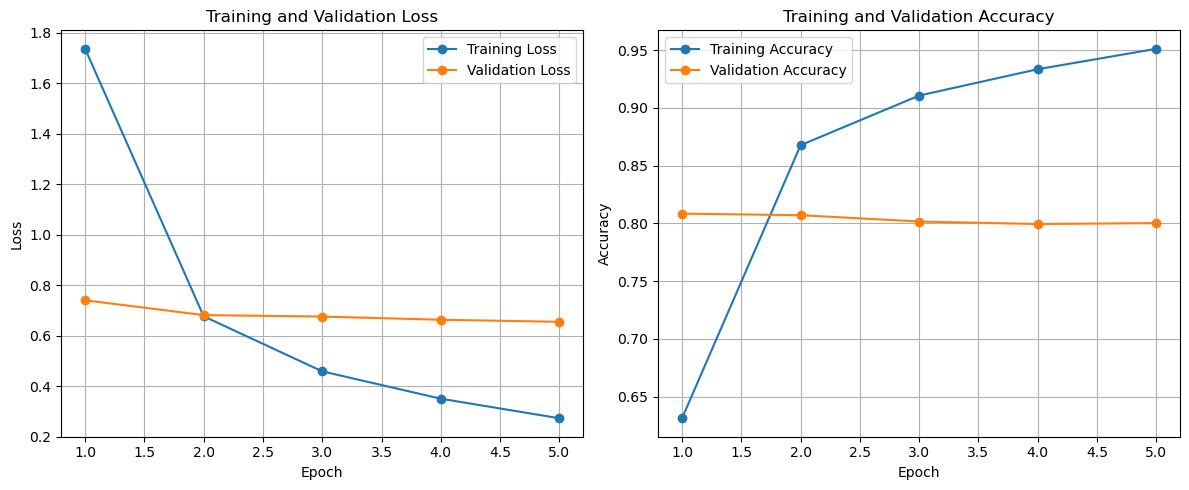

In [15]:
# --- Plotting Training & Validation Metrics ---
# Assumes train_losses, val_losses, train_accs, val_accs lists exist from the previous cell.

import matplotlib.pyplot as plt

# Create epoch range for x-axis (e.g., if num_epochs=5, this is [1, 2, 3, 4, 5])
epochs_range = range(1, num_epochs + 1)

# Create a figure with two subplots: one for loss, one for accuracy
plt.figure(figsize=(12, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1) # (rows, columns, panel number)
plt.plot(epochs_range, train_losses, 'o-', label='Training Loss') # 'o-' creates markers and lines
plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend() # Show legend based on labels
plt.grid(True) # Add a grid for easier reading

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, 'o-', label='Training Accuracy')
plt.plot(epochs_range, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout to prevent titles/labels overlapping
plt.tight_layout()

# Display the plots
plt.show()

### Interpreting Feature Extraction Results

After just a few epochs of training only the classifier head (Feature Extraction), you should observe:
* *Loss Decreasing:* Both training and validation loss should generally decrease.
* *Accuracy Increasing:* Both training and validation accuracy should increase significantly from random chance (~2.7% for 37 classes). Reaching accuracies above 50% or even higher is common in this phase, demonstrating the power of the pre-trained features.
* *Speed:* This phase should be relatively fast because backpropagation only happens through the final layer.

Next lecture, we'll build on this foundation by doing the following:
1.  *Full Evaluation:* Implement more detailed evaluation metrics (Precision, Recall, F1, Confusion Matrix).
2.  *Data Augmentation:* Add techniques like random flips and crops to the training data to improve generalization.
3.  *Fine-Tuning:* Unfreeze some of the later layers of the base model and train them with a low learning rate (Differential Learning Rates).

In [16]:
# --- Load and Adapt ResNet18 ---

print("\nLoading pre-trained ResNet18...")
# Load ResNet18 with the best available ImageNet weights
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# Display the model architecture
print(resnet18)

# --- Freeze all parameters in the base model ---
print("Freezing base model parameters...")
for param in resnet18.parameters():
    param.requires_grad = False

# --- Replace the classifier head ---
# ResNet's classifier is typically the `fc` (fully connected) layer.
num_ftrs_resnet = resnet18.fc.in_features
print(f"Original ResNet18 fc layer input features: {num_ftrs_resnet}")

# Create a new nn.Linear layer for our 37 classes
# Parameters have requires_grad=True by default.
resnet18.fc = nn.Linear(num_ftrs_resnet, num_classes)
print("Replaced ResNet18 classifier head (fc layer).")

# --- Verify which parameters are trainable ---
print("\nTrainable parameters in modified ResNet18:")
total_params_resnet = 0
trainable_params_resnet = 0
for name, param in resnet18.named_parameters():
    total_params_resnet += param.numel()
    if param.requires_grad:
        print(f"  - {name} (Size: {param.shape}, Params: {param.numel()})")
        trainable_params_resnet += param.numel()

print(f"\nTotal parameters in ResNet18: {total_params_resnet:,}")
print(f"Trainable parameters (classifier head only): {trainable_params_resnet:,}")


Loading pre-trained ResNet18...
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
# --- Feature Extraction Training Run ---

# Let's use ResNet18 for the first run.
model_to_train = resnet18
model_name = "ResNet18_FeatureExtract"

# Move the model to the chosen device
model_to_train = model_to_train.to(device)
print(f"Training model: {model_name} on {device}")

# --- Define Loss and Optimizer ---
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
# IMPORTANT: We only want to optimize the parameters of the NEW classifier head.
# We can filter parameters based on requires_grad == True.
params_to_update = []
print("\nParameters to be optimized:")
for name, param in model_to_train.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print(f"  - {name}")

optimizer = optim.Adam(params_to_update, lr=0.001) # Common learning rate for Adam
print("\nOptimizer created (Adam, lr=0.001) targeting only the classifier head.")

Training model: ResNet18_FeatureExtract on mps

Parameters to be optimized:
  - fc.weight
  - fc.bias

Optimizer created (Adam, lr=0.001) targeting only the classifier head.


In [18]:
# --- Training Loop ---
num_epochs = 5 # Train for a few epochs for demonstration
print(f"\nStarting Feature Extraction training for {num_epochs} epochs...")

start_time_train = time.time()

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(model_to_train, dataloaders['train'], criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

    # Validate
    val_loss, val_acc = validate(model_to_train, dataloaders['val'], criterion, device)
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # --- Store metrics for plotting ---
    train_losses.append(train_loss)
    train_accs.append(train_acc) # Use .item() to get scalar value if it's a tensor
    val_losses.append(val_loss)
    val_accs.append(val_acc) # Use .item() to get scalar value if it's a tensor

end_time_train = time.time()
training_duration = end_time_train - start_time_train
print(f"\nTraining finished in {training_duration // 60:.0f}m {training_duration % 60:.0f}s")

# --- The variables train_losses, val_losses, train_accs, val_accs now hold the history ---
print("\nMetric history collected:")
print(f"Train Losses per epoch: {[f'{x:.4f}' for x in train_losses]}")
print(f"Val Losses per epoch:   {[f'{x:.4f}' for x in val_losses]}")
print(f"Train Accs per epoch:   {[f'{x:.4f}' for x in train_accs]}")
print(f"Val Accs per epoch:     {[f'{x:.4f}' for x in val_accs]}")


Starting Feature Extraction training for 5 epochs...

Epoch 1/5
----------
Train Loss: 1.9084 Acc: 0.5788
Val Loss: 0.9563 Acc: 0.7991

Epoch 2/5
----------
Train Loss: 0.7172 Acc: 0.8592
Val Loss: 0.6212 Acc: 0.8512

Epoch 3/5
----------
Train Loss: 0.5020 Acc: 0.8886
Val Loss: 0.5372 Acc: 0.8569

Epoch 4/5
----------
Train Loss: 0.3972 Acc: 0.9130
Val Loss: 0.4790 Acc: 0.8659

Epoch 5/5
----------
Train Loss: 0.3355 Acc: 0.9258
Val Loss: 0.4542 Acc: 0.8697

Training finished in 8m 41s

Metric history collected:
Train Losses per epoch: ['1.9084', '0.7172', '0.5020', '0.3972', '0.3355']
Val Losses per epoch:   ['0.9563', '0.6212', '0.5372', '0.4790', '0.4542']
Train Accs per epoch:   ['0.5788', '0.8592', '0.8886', '0.9130', '0.9258']
Val Accs per epoch:     ['0.7991', '0.8512', '0.8569', '0.8659', '0.8697']


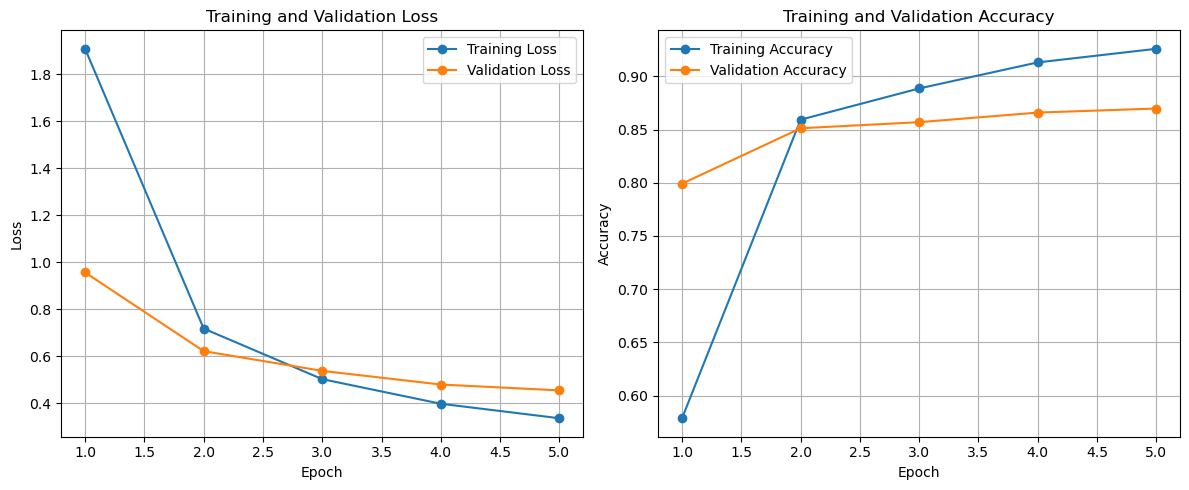

In [19]:
# --- Plotting Training & Validation Metrics ---
# Assumes train_losses, val_losses, train_accs, val_accs lists exist from the previous cell.

import matplotlib.pyplot as plt

# Create epoch range for x-axis (e.g., if num_epochs=5, this is [1, 2, 3, 4, 5])
epochs_range = range(1, num_epochs + 1)

# Create a figure with two subplots: one for loss, one for accuracy
plt.figure(figsize=(12, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 1) # (rows, columns, panel number)
plt.plot(epochs_range, train_losses, 'o-', label='Training Loss') # 'o-' creates markers and lines
plt.plot(epochs_range, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend() # Show legend based on labels
plt.grid(True) # Add a grid for easier reading

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, 'o-', label='Training Accuracy')
plt.plot(epochs_range, val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout to prevent titles/labels overlapping
plt.tight_layout()

# Display the plots
plt.show()

### Homework: Feature Extraction for ResNet18 (to be completed by Wednesday, Apr 30)

**Goal:** Reinforce the complete "Feature Extraction" pipeline (data loading with normalization, model adaptation, optimizer setup, training loop) by applying it to the *second* project model (ResNet18). This ensures you have a working baseline for both models before moving to fine-tuning in Lecture 3.

**Tasks:**

1.  **Adapt Lecture 2 Code:** You should be working within this Jupyter Notebook from Lecture 2, which implemented and ran Feature Extraction for MobileNetV3 on the Pet dataset.
2.  **Target ResNet18:** Modify the "Feature Extraction Training Run" section (likely starting around Cell 8):
    * Change the `model_to_train` variable to use the `resnet18` model instance (which was already loaded and adapted earlier in this notebook).
    * Update the `model_name` variable accordingly (e.g., `"ResNet18_FeatureExtract"`).
    * Double-check that the `optimizer` is correctly configured to target *only* the trainable parameters of the modified `resnet18` model (i.e., the parameters of the new `resnet18.fc` layer). The code provided, which filters `params_to_update` based on `param.requires_grad`, should handle this correctly. Keep the loss function (`nn.CrossEntropyLoss`) and Adam learning rate (`lr=0.001`) the same as the MobileNetV3 run for a fair comparison at this stage.
3.  **Run Training:** Execute the training loop for the same number of epochs used for the MobileNetV3 demo in this lecture (e.g., 5 epochs).
4.  **Report Results:** Ensure the output cells clearly display the final training loss, training accuracy, validation loss, and validation accuracy achieved by ResNet18 after the training run completes.
5.  **Brief Comparison:** Add a short Markdown cell at the end comparing the final validation accuracy of ResNet18 (from your run) to the final validation accuracy achieved by MobileNetV3 in the lecture's demo run. Just a sentence or two noting which performed better in this initial feature extraction phase is sufficient.